In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

from tqdm.auto import tqdm, trange
from collections import Counter
import random
from torch import optim

from torch.utils.tensorboard import SummaryWriter

# Helpful for computing cosine similarity--Note that this is NOT a similarity!
from scipy.spatial.distance import cosine

# Handy command-line argument parsing
import argparse

# Sort of smart tokenization
from nltk.corpus import stopwords  # import the stopwords
from nltk.tokenize import RegexpTokenizer

# We'll use this to save our models
from gensim.models import KeyedVectors

#
# IMPORTANT NOTE: Always set your random seeds when dealing with stochastic
# algorithms as it lets your bugs be reproducible and (more importantly) it lets
# your results be reproducible by others.
#
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)

In [34]:
class Corpus:
    
    def __init__(self):

        self.tokenizer = RegexpTokenizer(r'\w+')

        self.word_to_index = {} # word to unique-id
        self.index_to_word = {} # unique-id to word

        # How many times each word occurs in our data after filtering
        self.word_counts = Counter()
        self.unique_words = []   # unique word list, also rank by its frequency, but it is not required
        self.unique_words_freq = [] # the corresponding frequence list

        # A utility data structure that lets us quickly sample "negative"
        # instances in a context. This table contains unique-ids
        self.negative_sampling_table = []
        
        # The dataset we'll use for training, as a sequence of unqiue word
        # ids. This is the sequence across all documents after tokens have been
        # randomly subsampled by the word2vec preprocessing step
        self.word_sub_prob = {}
        self.full_token_sequence_as_ids = []
        
    def tokenize(self, text):
        '''
        Tokenize the document and returns a list of the tokens
        '''
        return self.tokenizer.tokenize(text)        

    def load_data(self, file_name, min_token_freq):
        '''
        Reads the data from the specified file as long long sequence of text
        (ignoring line breaks) and populates the data structures of this
        word2vec object.
        '''

        # Step 1: Read in the file and create a long sequence of tokens for
        # all tokens in the file
        data_txt = open(file_name, "r").read()
        all_tokens = self.tokenizer.tokenize(data_txt)
        all_tokens = [i.lower() for i in all_tokens]
        print('Reading data and tokenizing')
        # return all_tokens
    
        # Step 2: Count how many tokens we have of each type
        token_counts = Counter(all_tokens)
        # return self.word_counts
        print('Counting token frequencies')

        # Step 3: Replace all tokens below the specified frequency with an <UNK> token. 
        print("Performing minimum thresholding")
        for i in range(len(all_tokens)):
            if token_counts[all_tokens[i]] < min_token_freq:
                all_tokens[i] = '<UNK>'
                
        # Step 3.1: Delete all the stopwords
        print("Performing stopwords removal")
        all_tokens = [i for i in all_tokens if i not in stopwords.words('english')]
                
        # step4:
        self.word_counts = Counter(all_tokens)
            
        
        # Step 5: Create the mapping word and integer
        print("Performing word mapping")
        word_rank = sorted(self.word_counts.items(), key=lambda x: x[1], reverse=True)   # rank the word_counts based on frequency
        word_list = [word[0] for word in word_rank]  # word_rank is a list of tuples.ex[('to', 10)], the word_list is unique list
        word_freq = [word[1] for word in word_rank]
    
        self.unique_words = word_list
        self.unique_words_freq = word_freq
        
        for i in range(len(word_list)):
            self.word_to_index[word_list[i]] = i
            self.index_to_word[i] = word_list[i]
            
            
        # Step 6: perform word subsampling
        print("Performing word subsampling")
        word_number = sum(self.word_counts.values())
        for w in self.unique_words:
            p = self.word_counts[w] / word_number
            self.word_sub_prob[w] = (np.sqrt(p/0.001) + 1) * (0.001/p)  # calculate the probability
            
        # Steo 6.1: keep the word based on the probability
        for t in all_tokens:
            t_prob = min(1, self.word_sub_prob[t])            
            if np.random.choice([0,1], p=[1-t_prob, t_prob]) == 1:
                self.full_token_sequence_as_ids.append(self.word_to_index[t])       
        
        
        #self.full_token_sequence_as_ids = [self.word_to_index[word] for word in all_tokens]

        # Helpful print statement to verify what you've loaded
        print('Loaded all data from %s; saw %d tokens (%d unique)' \
              % (file_name, len(self.full_token_sequence_as_ids),
                 len(self.word_to_index)))
        
    def generate_negative_sampling_table(self, exp_power=0.75, table_size=1e6):
     
        print("Generating sampling table")
        # unique words is a sorted word list, now to find the corresponding frequency

        power_array = np.power(np.array(self.unique_words_freq), exp_power)
        prob_array = power_array / np.sum(power_array)

        # print(np.sum(prob_array))  # to check if the summation is 1

        # Step 2: Create the table to the correct size. You'll want this to be a
        # numpy array of type int
        # Step 3: Fill the table so that each word has a number of IDs
        # proportionate to its probability of being sampled.
        table = np.array([], dtype = np.int32)
        for ind, val in enumerate(prob_array):
            temp_array = np.full(round(val * table_size), ind)
            table = np.hstack((table, temp_array))
            
        self.negative_sampling_table = table
            
        return table    
        print(len(table))


    def generate_negative_samples(self, cur_context_word_id, num_samples):  # the word_id is also a list

        results = []
        while len(results) < num_samples:
            random_neg = np.random.choice(self.negative_sampling_table)  # return an int
            if random_neg not in cur_context_word_id:
                results.append(random_neg)

        return results

In [79]:
corpus = Corpus()
corpus.load_data('wiki-bios.med.txt', 5)
corpus.generate_negative_sampling_table()
# corpus.full_token_sequence_as_ids

Reading data and tokenizing
Counting token frequencies
Performing minimum thresholding
Loaded all data from wiki-bios.med.txt; saw 13713906 tokens (96572 unique)
Generating sampling table


array([    0,     0,     0, ..., 96569, 96570, 96571])

In [80]:
window_size = 2
num_negative_samples_per_target = 2

training_data = []
# looping_times = 10
looping_times = len(corpus.full_token_sequence_as_ids)
    
# Loop through each token in the corpus and generate an instance for each, 
# adding it to training_data
for n in trange(looping_times):
    
    target = [corpus.full_token_sequence_as_ids[n]]   # convert the target to be a list
    instance_tup = ()
    
    if target != [corpus.word_to_index['<UNK>']]:
        if n - window_size < 0:   # left edge of the corpus
            context = corpus.full_token_sequence_as_ids[0: n] + corpus.full_token_sequence_as_ids[n+1: n+window_size+1]
            negative_sample = corpus.generate_negative_samples(context + target, num_negative_samples_per_target*window_size*2 + 2*window_size - len(context))
            word_id = context + negative_sample
            predicted_labels = np.hstack((np.full(len(context), 1, dtype=np.float32), np.full(len(negative_sample), 0, dtype=np.float32)))
            instance_tup = (np.array(target), np.array(word_id), predicted_labels)

        elif n + window_size >= looping_times:   # right edge of the corpus
            context = corpus.full_token_sequence_as_ids[n-window_size: n] + corpus.full_token_sequence_as_ids[n+1:looping_times]
            negative_sample = corpus.generate_negative_samples(context + target, num_negative_samples_per_target*window_size*2 + 2*window_size - len(context))
            word_id = context + negative_sample
            predicted_labels = np.hstack((np.full(len(context), 1, dtype=np.float32), np.full(len(negative_sample), 0, dtype=np.float32)))
            instance_tup = (np.array(target), np.array(word_id), predicted_labels)

        else:
            context = corpus.full_token_sequence_as_ids[n-window_size: n] + corpus.full_token_sequence_as_ids[n+1: n+window_size+1]
            negative_sample = corpus.generate_negative_samples(context + target, num_negative_samples_per_target*window_size*2)
            word_id = context + negative_sample
            predicted_labels = np.hstack((np.full(len(context), 1, dtype=np.float32), np.full(len(negative_sample), 0, dtype=np.float32)))
            instance_tup = (np.array(target), np.array(word_id), predicted_labels)
            
        training_data.append(instance_tup)

  0%|          | 0/13713906 [00:00<?, ?it/s]

In [81]:
print(len(training_data))
training_data[10]

13621971


(array([56638]),
 array([  268,  7249,  8092,   407, 28066, 12765,     4, 58690,  2140,
         3518, 69058,  1722]),
 array([1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32))

In [82]:
class Word2Vec(nn.Module):
    
    def __init__(self, vocab_size, embedding_size):
        super(Word2Vec, self).__init__()
        
        self.target_embeddings = nn.Embedding(vocab_size, embedding_size)
        self.context_embeddings = nn.Embedding(vocab_size, embedding_size)
        
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.init_emb(init_range=0.5/self.vocab_size)
        
        self.sm = nn.Sigmoid()
        
        
    def init_emb(self, init_range):
        
        self.target_embeddings.weight.data.uniform_(-init_range, init_range)
        self.context_embeddings.weight.data.uniform_(-init_range, init_range)

        
    def forward(self, target_word_id, context_word_ids):
        
        vt = self.target_embeddings(target_word_id)  # target word is a tensor
        vc = self.context_embeddings(context_word_ids)
        out = torch.bmm(vc, vt.squeeze().unsqueeze(2)).squeeze()
        return self.sm(out)

In [85]:
# TODO: Set your training stuff, hyperparameters, models, tensorboard writer etc. here
batch_size = 64
vocab_size = len(corpus.word_to_index)
k = 50   # The dimension of the embedding
learning_rate = 5e-5
epochs = 2
train_loader = torch.utils.data.DataLoader(dataset=training_data,    # load the data
                                           batch_size=batch_size, 
                                           shuffle=True)
total_step = len(train_loader)
w2v = Word2Vec(vocab_size, k)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(w2v.parameters(), lr=learning_rate)
max_steps = 10000

writer = SummaryWriter()  # tensorboard summary writer

# HINT: wrapping the epoch/step loops in nested tqdm calls is a great way
# to keep track of how fast things are and how much longer training will take

for epoch in range(epochs):

    loss_sum = 0    
    # TODO: use your DataLoader to iterate over the data
    for step, data in enumerate(tqdm(train_loader)):

        # NOTE: since you created the data as a tuple of three np.array instances,
        # these have now been converted to Tensor objects for us
        target_ids, context_ids, labels = data        
        outputs = w2v(target_ids, context_ids)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        
        loss_sum +=loss.item()
        
        if (step+1) % 100 == 0:
            # print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
            #        .format(epoch+1, epochs, step+1, total_step, loss_sum))
            writer.add_scalar("Loss/train", loss_sum, step+1)  # add to the tensor board
            loss_sum = 0
            
        # if step > max_steps:
        #     break
            
writer.flush()

  0%|          | 0/212844 [00:00<?, ?it/s]

  0%|          | 0/212844 [00:00<?, ?it/s]

In [107]:
# test the runtime of different batch sizes

batch_size = 512
vocab_size = len(corpus.word_to_index)
k = 50   # The dimension of the embedding
learning_rate = 5e-5
epochs = 1
train_loader = torch.utils.data.DataLoader(dataset=training_data,    # load the data
                                           batch_size=batch_size, 
                                           shuffle=True)
total_step = len(train_loader)
w2v_test = Word2Vec(vocab_size, k)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(w2v_test.parameters(), lr=learning_rate)
max_steps = 1000

for epoch in range(epochs):
    for step, data in enumerate(tqdm(train_loader)):
        target_ids, context_ids, labels = data        
        outputs = w2v_test(target_ids, context_ids)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        
        loss_sum +=loss.item()
        if step > max_steps:
            break
            

  0%|          | 0/26606 [00:00<?, ?it/s]

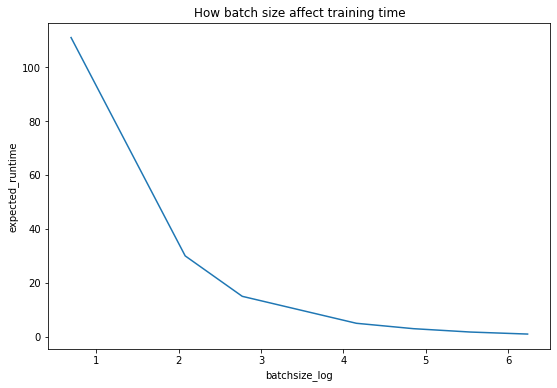

In [112]:
import matplotlib.pyplot as plt

batchsize = [2, 8, 16, 32, 64, 128, 256, 512]
expected_runtime = [111, 30, 15, 10, 5, 3, 1.75, 1]

x_1 = np.log(np.array(batchsize))
y_1 = np.array(expected_runtime)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(x_1, y_1)
ax.set_xlabel('batchsize_log'); ax.set_ylabel('expected_runtime')
ax.set_title('How batch size affect training time')
fig.savefig("runtime_batch.jpg",bbox_inches='tight', dpi=144)

In [116]:
w2v.eval()
def get_neighbors(model, word_to_index, target_word):
    """ 
    Finds the top 10 most similar words to a target word
    """
    outputs = []
    for word, index in tqdm(word_to_index.items(), total=len(word_to_index)):
        similarity = compute_cosine_similarity(model, word_to_index, target_word, word)
        result = {"word": word, "score": similarity}
        outputs.append(result)

    # Sort by highest scores
    neighbors = sorted(outputs, key=lambda o: o['score'], reverse=True)
    return neighbors[1:11]

def compute_cosine_similarity(model, word_to_index, word_one, word_two):
    '''
    Computes the cosine similarity between the two words
    '''
    try:
        word_one_index = word_to_index[word_one]
        word_two_index = word_to_index[word_two]
    except KeyError:
        return 0

    embedding_one = model.target_embeddings(torch.LongTensor([word_one_index]))
    embedding_two = model.target_embeddings(torch.LongTensor([word_two_index]))
    similarity = 1 - abs(float(cosine(embedding_one.detach().numpy(),
                                      embedding_two.detach().numpy())))
    return similarity

get_neighbors(w2v, corpus.word_to_index, "april")

  0%|          | 0/96572 [00:00<?, ?it/s]

[{'word': 'march', 'score': 0.9984798431396484},
 {'word': 'october', 'score': 0.9982365965843201},
 {'word': 'february', 'score': 0.997121274471283},
 {'word': 'december', 'score': 0.9958194494247437},
 {'word': 'november', 'score': 0.9956890344619751},
 {'word': 'september', 'score': 0.9950610399246216},
 {'word': 'june', 'score': 0.9948214888572693},
 {'word': 'july', 'score': 0.992501974105835},
 {'word': 'august', 'score': 0.990580141544342},
 {'word': 'january', 'score': 0.9894656538963318}]

In [96]:
def save(model, corpus, filename):
    '''
    Saves the model to the specified filename as a gensim KeyedVectors in the
    text format so you can load it separately.
    '''

    # Creates an empty KeyedVectors with our embedding size
    kv = KeyedVectors(vector_size=model.embedding_size)        
    vectors = []
    words = []
    # Get the list of words/vectors in a consistent order
    for index in trange(model.target_embeddings.num_embeddings):
        word = corpus.index_to_word[index]
        vectors.append(model.target_embeddings(torch.LongTensor([index])).detach().numpy()[0])
        words.append(word)

    # Fills the KV object with our data in the right order
    kv.add_vectors(words, vectors) 
    kv.save_word2vec_format(filename, binary=False)

In [97]:
save(w2v, corpus, "batch64_epoch2.kv")

  0%|          | 0/96572 [00:00<?, ?it/s]